In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from stochax import OrnsteinUhlenbeck
from itertools import product

In [2]:
kappa = 0.25
alpha=1.
sigma=0.5

process = OrnsteinUhlenbeck(kappa=kappa, alpha=alpha, sigma=sigma)
n_steps = 250
delta = 1/n_steps

n_samples = 250

realizations = process.simulate(
    initial_value=0.5,
    delta=delta,
    n_simulations=n_samples,
    n_steps=n_steps
)

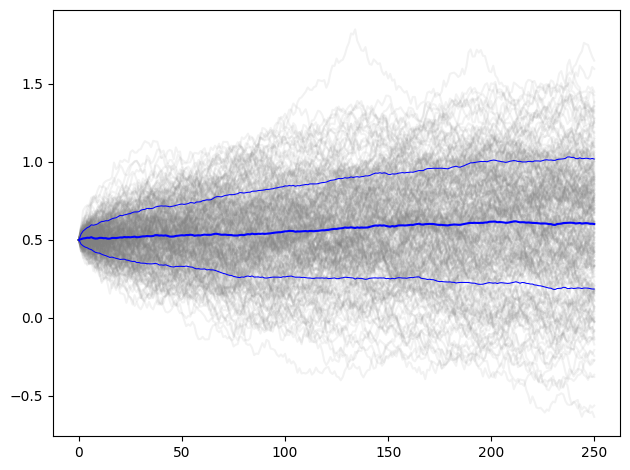

In [3]:
m = realizations.mean(axis=1)
s = realizations.std(axis=1)

fig, ax = plt.subplots(1, 1)

ax.plot(realizations, color='gray', alpha=0.1)
ax.plot(m, color='blue')
ax.plot(m+s, color='blue', linewidth=0.75)
ax.plot(m-s, color='blue', linewidth=0.75)

fig.tight_layout()

In [4]:
calibrations = list()

methods = ('mle', 'parametric_bootstrap')
grid = product(methods, realizations.columns)

for method, col in tqdm(grid):
    x = realizations[col]
    try:
        res = process.calibrate(
            x,
            delta=delta,
            method=method
        )
    
        calibrations.append({'method': method, **process.parameters})
    except:
        pass

500it [00:38, 13.15it/s]  


In [5]:
calibrations = pd.DataFrame(calibrations)

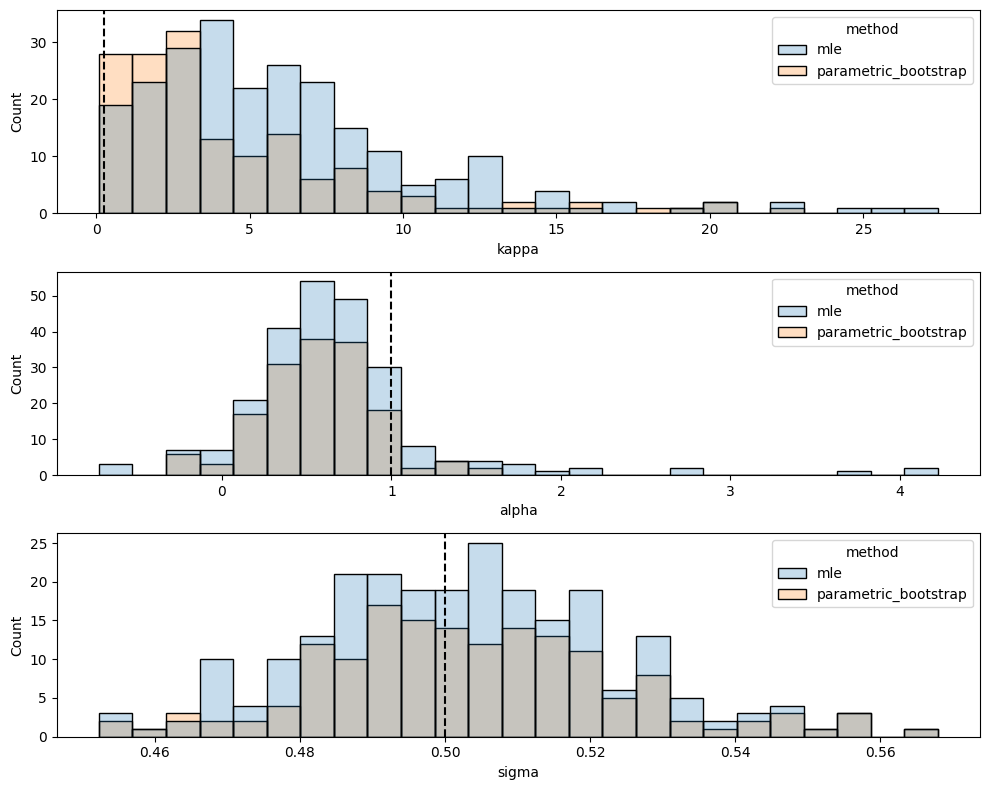

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8))

sns.histplot(calibrations, x='kappa', hue='method', bins=25, alpha=0.25, ax=ax[0])
ax[0].axvline(kappa, linestyle='dashed', color='black')

sns.histplot(calibrations, x='alpha', hue='method', bins=25, alpha=0.25, ax=ax[1])
ax[1].axvline(alpha, linestyle='dashed', color='black')

sns.histplot(calibrations, x='sigma', hue='method', bins=25, alpha=0.25, ax=ax[2])
ax[2].axvline(sigma, linestyle='dashed', color='black')

fig.tight_layout()

In [7]:
calibrations['delta_kappa'] = calibrations['kappa'] - kappa
calibrations['delta_alpha'] = calibrations['alpha'] - alpha
calibrations['delta_sigma'] = calibrations['sigma'] - sigma

In [8]:
def rmse(x):
    v = x.dropna().values
    return np.sqrt(np.mean(v**2))
    
calibrations.groupby('method').agg(
    rmse_kappa=('delta_kappa', rmse),
    rmse_alpha=('delta_alpha', rmse),
    rmse_sigma=('delta_sigma', rmse)
)

,rmse_kappa,rmse_alpha,rmse_sigma
method,,,
mle,7.583905,0.683329,0.020920
parametric_bootstrap,6.104300,0.544051,0.021131
